In [1]:
! ./setup.sh

downloading http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
downloaded inception_v3.ckpt
downloading https://github.com/anishathalye/obfuscated-gradients/releases/download/v0/quilt_db.tar.gz
downloaded quilt_db.npy


In [2]:
import tensorflow as tf
import numpy as np
import inceptionv3
from utils import *
from defense import *

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
sess = tf.Session()

# Image and target class

Choose what you want here.

In [4]:
orig = load_image('cat.jpg')
TARGET = 924 # guacamole

# Classifier

In [5]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

INFO:tensorflow:Scale of 0 disables regularizer.

Instructions for updating:
Please use `layer.__call__` method instead.





INFO:tensorflow:Restoring parameters from /home/nghia-dinh/Projects/adversarial-obfuscated-gradients/inputtransformations/data/inception_v3.ckpt


In [6]:
probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

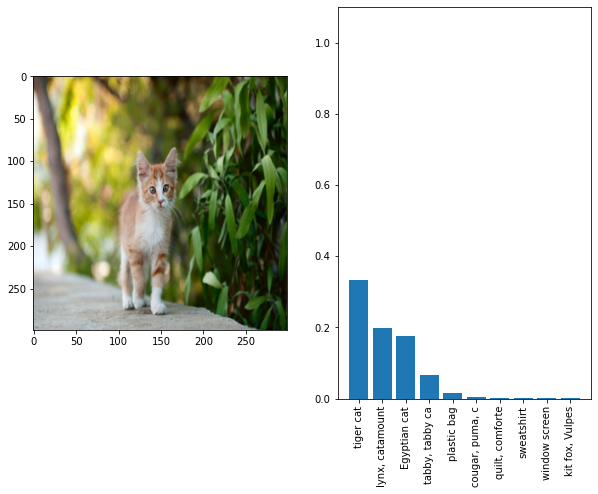

In [7]:
classify(orig, target_class=TARGET)

# Failed attack (attempting to transfer)

In [8]:
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
normalized_l2_loss = tf.nn.l2_loss(l2_orig - l2_x) / tf.nn.l2_loss(l2_orig)

xent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
lam = tf.placeholder(tf.float32, ())
loss = xent + lam * normalized_l2_loss
grad, = tf.gradients(loss, x)

In [9]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(10):
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=282
step 1, l2=0.000064, pred=230
step 2, l2=0.000085, pred=263
step 3, l2=0.000097, pred=282
step 4, l2=0.000122, pred=924
step 5, l2=0.000155, pred=924
step 6, l2=0.000166, pred=924
step 7, l2=0.000166, pred=924
step 8, l2=0.000166, pred=924
step 9, l2=0.000166, pred=924


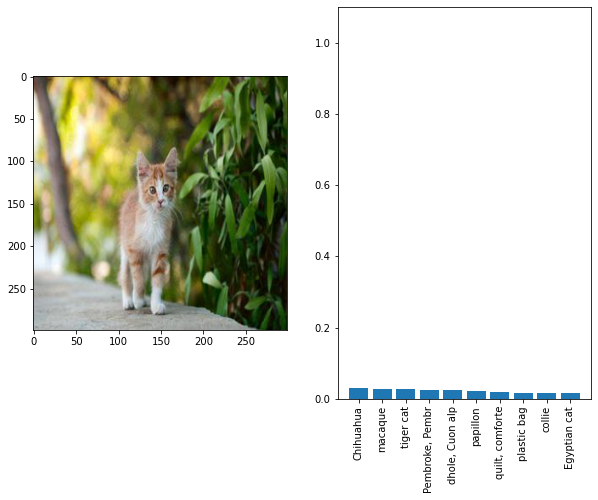

In [10]:
classify(defend_jpeg(adv), target_class=TARGET)

# Attack

Using BPDA.

In [11]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(10):
    adv_def = defend_jpeg(adv)
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv_def, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=285
step 1, l2=0.000068, pred=277
step 2, l2=0.000086, pred=272
step 3, l2=0.000111, pred=282
step 4, l2=0.000132, pred=263
step 5, l2=0.000156, pred=157
step 6, l2=0.000186, pred=728
step 7, l2=0.000224, pred=924
step 8, l2=0.000266, pred=924
step 9, l2=0.000290, pred=924


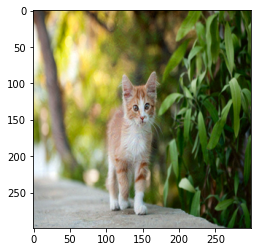

In [12]:
import matplotlib.pyplot as plt
plt.imshow(adv)

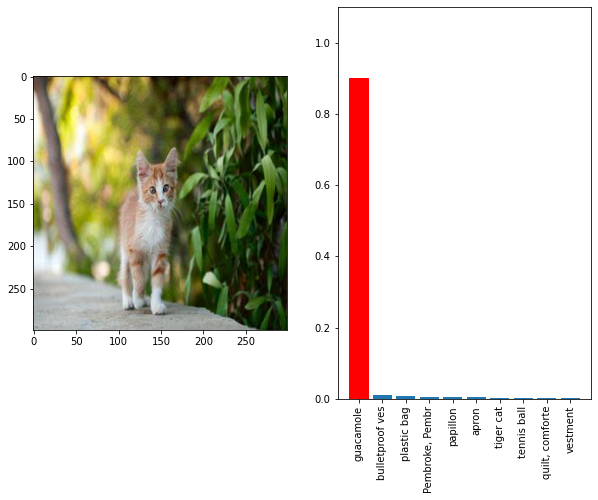

In [13]:
classify(defend_jpeg(adv), target_class=TARGET)